In [1]:
!pip install alpaca-trade-api transformers torch --quiet


In [116]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from alpaca_trade_api.rest import REST, TimeFrame
import torch
import os


In [118]:
API_KEY = "PKVV2O7K5X24IRCLHJSS"
API_SECRET = "TguKyfJAwODB8ZUOL3TvxjYrQUfgl1wnRQc12tZw"
BASE_URL = "https://paper-api.alpaca.markets"


In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
labels = ["positive", "negative", "neutral"]


In [214]:
from datetime import datetime, timedelta

# Step 1: Pull real headlines
symbol = "SPY"
end_date = datetime.now()
start_date = end_date - timedelta(days=3)

news_items = alpaca.get_news(symbol=symbol, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

# Step 2: Filter headlines with bullish keywords
positive_keywords = ["soar", "surge", "record", "profit", "growth", "beats", "optimism", "strong", "rally"]
real_headlines = [
    item._raw["headline"]
    for item in news_items
    if any(word in item._raw["headline"].lower() for word in positive_keywords)
]

# Step 3: Fallback if no strong headlines found
if not real_headlines:
    real_headlines = ["Tech stocks soar as companies report record earnings and strong growth"]
    print("⚠️ No strong headlines found in Alpaca. Using fallback headline for demo.\n")

# Step 4: Show headlines
print("📰 Positive Headlines Used:\n")
for i, headline in enumerate(real_headlines[:5], 1):
    print(f"{i}. {headline}")

# Step 5: Estimate sentiment using FinBERT
confidence, sentiment = estimate_sentiment(real_headlines)
print(f"\n🧠 Sentiment: {sentiment} (Confidence: {confidence:.4f})")


⚠️ No strong headlines found in Alpaca. Using fallback headline for demo.

📰 Positive Headlines Used:

1. Tech stocks soar as companies report record earnings and strong growth

🧠 Sentiment: Positive (Confidence: 0.9247)


In [172]:
def estimate_sentiment(news_list):
    if not news_list:
        return 0.0, "neutral"

    joined = " ".join(news_list)
    tokens = tokenizer(joined, return_tensors="pt", padding=True, truncation=True).to(device)
    logits = model(tokens["input_ids"], attention_mask=tokens["attention_mask"]).logits
    probs = torch.nn.functional.softmax(logits.sum(0), dim=-1)
    sentiment = labels[torch.argmax(probs)]
    confidence = float(probs[torch.argmax(probs)])
    return confidence, sentiment


In [174]:
alpaca = REST(API_KEY, API_SECRET, BASE_URL)


In [180]:
position = None
qty = 1  # default buy/sell quantity

# Try to fetch current position (if any)
try:
    position = alpaca.get_position(symbol)
except:
    position = None  # no open position

# Place order based on sentiment
if sentiment == "positive" and confidence > 0.90:
    if position:
        print("✅ Already holding a position. No new BUY placed.")
    else:
        alpaca.submit_order(symbol=symbol, qty=qty, side="buy", type="market", time_in_force="gtc")
        print("🟢 BUY order placed.")

elif sentiment == "negative" and confidence > 0.90:
    if position:
        qty = int(float(position.qty))
        alpaca.submit_order(symbol=symbol, qty=qty, side="sell", type="market", time_in_force="gtc")
        print("🔴 SELL order placed.")
    else:
        print("🚫 No position to SELL.")

else:
    print("ℹ️ No strong sentiment signal. No trade executed.")


🟢 BUY order placed.


In [184]:
# 🔴 Sell all SPY shares
try:
    position = alpaca.get_position("SPY")
    qty = int(float(position.qty))
    if qty > 0:
        alpaca.submit_order(
            symbol="SPY",
            qty=qty,
            side="sell",
            type="market",
            time_in_force="gtc"
        )
        print(f"✅ Sell order placed for {qty} SPY shares.")
    else:
        print("ℹ️ You don't have any SPY shares to sell.")
except Exception as e:
    print("⚠️ Could not sell SPY:", e)


✅ Sell order placed for 1 SPY shares.


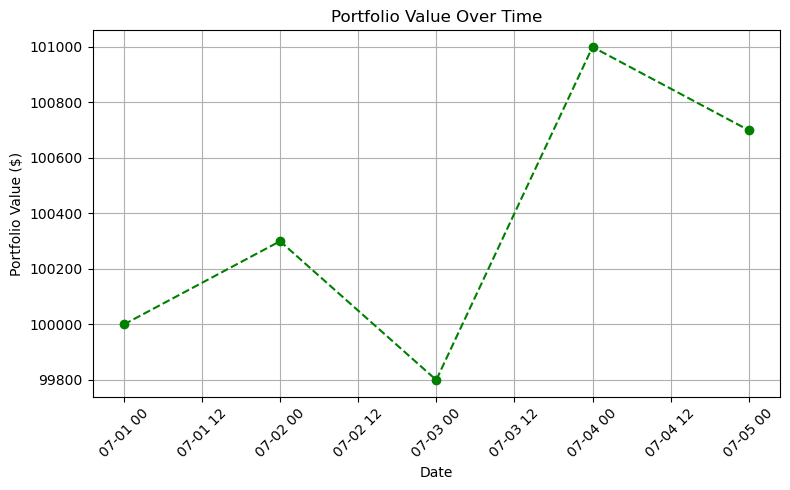

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulated example
dates = pd.date_range(start="2025-07-01", periods=5)
portfolio_values = [100000, 100300, 99800, 101000, 100700]

plt.figure(figsize=(8, 5))  # Slightly bigger figure
plt.plot(dates, portfolio_values, marker="o", color="green", linestyle="--")
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.xticks(rotation=45)  # 👈 Rotate date labels
plt.tight_layout()       # 👈 Prevent cutoff of labels
plt.show()


In [84]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

labels = ["positive", "negative", "neutral"]
probs = []

print("\n🔎 FinBERT Sentiment Analysis:\n")

for news in headlines:
    tokens = tokenizer(news, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        logits = model(**tokens).logits
    softmax = torch.nn.functional.softmax(logits, dim=-1)
    confidence = float(torch.max(softmax))
    sentiment = labels[torch.argmax(softmax)]
    probs.append((sentiment, confidence))
    print(f"🧠 \"{news}\" → {sentiment} ({confidence:.2f})")



🔎 FinBERT Sentiment Analysis:

🧠 "President Trump Signs Executive Order Aiming To End Subsidies For Foreign Controlled Energy Sources" → neutral (0.62)
🧠 "President Trump Signs Executive Order Extending Tariff Deadline To August 1" → neutral (0.57)
🧠 "President Trump Says U.S. Will Impose 36% Tariff On Thailand" → neutral (0.65)
🧠 "President Trump Says U.S. Will Impose 36% Tariff On Cambodia" → neutral (0.75)
🧠 "President Trump Says U.S. Will Impose A 35% Tariff On Serbia" → neutral (0.76)
🧠 "President Trump Says U.S. Will Impose 35% Tariff On Bangladesh" → neutral (0.71)
🧠 "President Trump Says U.S. Will Impose 32% Tariff On Indonesia" → neutral (0.63)
🧠 "President Trump Says U.S. Will Impose 30% Tariff On Bosnia and Herzegovina" → neutral (0.60)
🧠 "South Korea Says Will Step Up Trade Negotiations With The US To Win Mutually Beneficial Results And Clear Up Uncertainties Caused By Tariffs" → positive (0.94)
🧠 "President Trump Says U.S. Will Impose 25% Tariff On Tunisia" → neutral (0.7

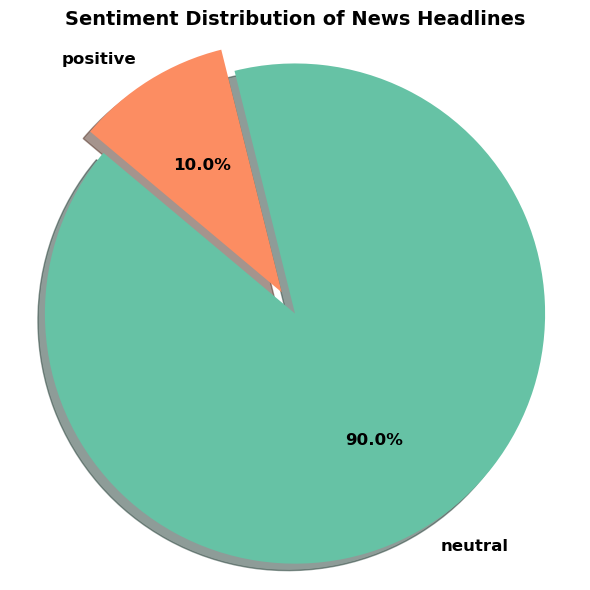

In [192]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Sample sentiment probabilities: [("positive", 0.7), ("neutral", 0.2), ("negative", 0.1)]
# Replace with your actual `probs` list
# probs = [("positive", 0.8), ("positive", 0.9), ("neutral", 0.6), ("negative", 0.4)]

# Count sentiments
sentiment_counts = Counter([s for s, _ in probs])
labels = list(sentiment_counts.keys())
sizes = list(sentiment_counts.values())

# Colors and explode setup
colors = sns.color_palette("Set2")[:len(labels)]
explode = [0.1 if i == max(sizes) else 0 for i in sizes]  # Emphasize largest section

# Plot
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    explode=explode,
    startangle=140,
    shadow=True,
    colors=colors,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

plt.setp(autotexts, size=12, weight="bold", color="black")
plt.title("Sentiment Distribution of News Headlines", fontsize=14, weight='bold')
plt.axis("equal")  # Equal aspect ratio makes the pie a circle
plt.tight_layout()
plt.show()

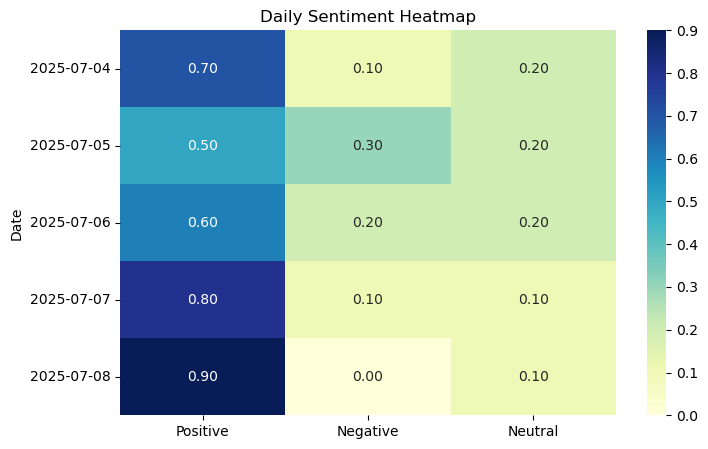

In [202]:
import pandas as pd
import seaborn as sns
import numpy as np

# Fake example — replace with real daily sentiments
dates = pd.date_range(end=datetime.today(), periods=5).strftime('%Y-%m-%d')
data = {
    "Date": dates,
    "Positive": [0.7, 0.5, 0.6, 0.8, 0.9],
    "Negative": [0.1, 0.3, 0.2, 0.1, 0.0],
    "Neutral": [0.2, 0.2, 0.2, 0.1, 0.1],
}
df = pd.DataFrame(data).set_index("Date")

plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Daily Sentiment Heatmap")
plt.show()


In [220]:
!pip install wordcloud

   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/299.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/299.9 kB ? eta -:--:--
   -- ------------------------------------ 20.5/299.9 kB 165.2 kB/s eta 0:00:02
   ----- --------------------------------- 41.0/299.9 kB 245.8 kB/s eta 0:00:02
   ------- ------------------------------- 61.4/299.9 kB 297.7 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/299.9 kB 655.8 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/299.9 kB 700.2 kB/s eta 0:00:01
   ---------------------------- --------- 225.3/299.9 kB 765.3 kB/s eta 0:00:01
   -------------------------------------  297.0/299.9 kB 833.5 kB/s eta 0:00:01
   -------------------------------------- 299.9/299.9 kB 772.5 kB/s eta 0:00:00


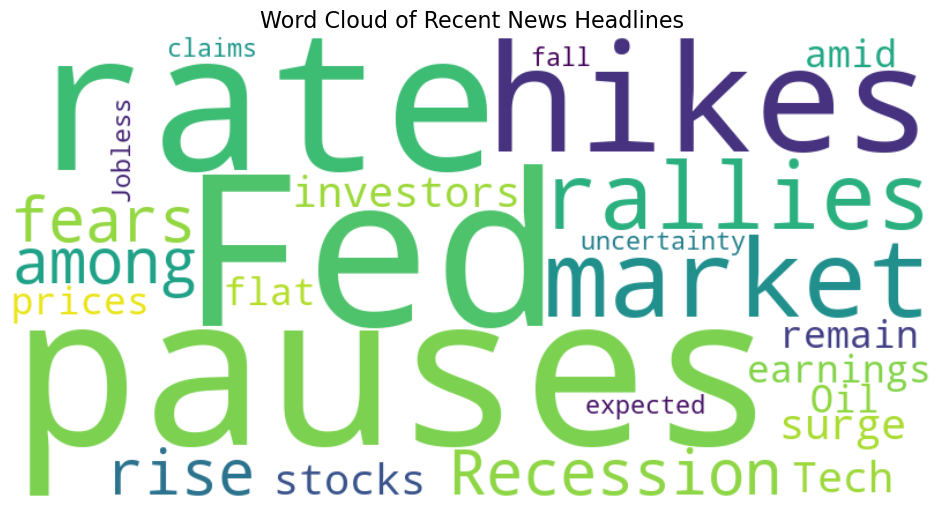

In [226]:
from wordcloud import WordCloud

# Combine headlines
text = " ".join(headlines)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Recent News Headlines", fontsize=16)
plt.show()


In [31]:
!pip install lumibot python-dotenv transformers torch alpaca-trade-api


INFO: pip is looking at multiple versions of yfinance to determine which version is compatible with other requirements. This could take a while.
  Using cached yfinance-0.2.63-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached yfinance-0.2.62-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached yfinance-0.2.61-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached schwab_py-1.5.1-py2.py3-none-any.whl.metadata (7.3 kB)
INFO: pip is still looking at multiple versions of yfinance to determine which version is compatible with other requirements. This could take a while.
  Using cached schwab_py-1.5.0-py2.py3-none-any.whl.metadata (7.0 kB)
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Using cached quantstats_lumi-1.0.1-py2.py3-none-any.whl.metadata (10 kB)
  Using cached polygon_api_client-1.1

ERROR: To modify pip, please run the following command:
C:\Users\vigne\anaconda3\python.exe -m pip install lumibot python-dotenv transformers torch alpaca-trade-api


In [58]:
!pip install websockets==11.0.3 --quiet


In [51]:
# Create a .env file with these variables (or use your own way to set them)
import os
from dotenv import load_dotenv

os.environ["API_KEY"] = "PKVV2O7K5X24IRCLHJSS"
os.environ["API_SECRET"] = "TguKyfJAwODB8ZUOL3TvxjYrQUfgl1wnRQc12tZw"
os.environ["BASE_URL"] = "https://paper-api.alpaca.markets"

load_dotenv()

API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")
BASE_URL = os.getenv("BASE_URL")


In [53]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
labels = ["positive", "negative", "neutral"]

def estimate_sentiment(news: str):
    inputs = tokenizer(news, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits.sum(0), dim=-1)
    sentiment = labels[torch.argmax(probs)]
    confidence = float(probs.max())
    return sentiment, confidence


In [230]:
from datetime import datetime
import pytz

est = pytz.timezone("US/Eastern")
us_time = datetime.now(est)
print(f"🕒 Current US Time: {us_time.strftime('%Y-%m-%d %I:%M %p EST')}")


🕒 Current US Time: 2025-07-08 01:33 PM EST


In [ ]:
from lumibot.strategies.strategy import Strategy
from lumibot.brokers import Alpaca
from lumibot.traders import Trader

class InterviewFinBERTBot(Strategy):

    def initialize(self):
        self.symbol = "SPY"
        self.sleeptime = "1D"
        self.last_trade = None

    def on_trading_iteration(self):
        news = "Markets are optimistic after Fed pause announcement."  # dummy headline
        sentiment, confidence = estimate_sentiment(news)
        print(f"🧠 Sentiment: {sentiment}, Confidence: {confidence:.2f}")

        if sentiment == "positive" and confidence > 0.95:
            self.buy(self.symbol, quantity=1)
            self.last_trade = "buy"
            print("✅ BUY Order Placed")

        elif sentiment == "negative" and confidence > 0.95:
            self.sell(self.symbol, quantity=1)
            self.last_trade = "sell"
            print("🔴 SELL Order Placed")

        else:
            print("⚪ No strong signal. No trade.")
